### Part 1 - Setup and Baseline

##### Download and load the data

In [56]:
import os
import pickle
import numpy as np

# Download if doesn't already exist - this expects the data to then exist in the current directory as 'cifar-10-batches-py'
if not os.path.exists('cifar-10-batches-py'):
    os.system('wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')
    os.system('tar -xvf cifar-10-python.tar.gz')
    os.system('rm cifar-10-python.tar.gz')

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

X_train = []
Y_train = []

# Load all the data, chunk by chunk
for i in range(1, 6):
    batch = unpickle(f'cifar-10-batches-py/data_batch_{i}')
    X_train.append(batch[b'data'])
    Y_train.append(batch[b'labels'])

# Concatenate the chunks
X_train = np.concatenate(X_train)
Y_train = np.concatenate(Y_train)

# Load the test data - single chunk
batch = unpickle('cifar-10-batches-py/test_batch')
X_test = batch[b'data']
Y_test = np.array(batch[b'labels'])

# Normalize the data (0-255 to 0-1)
X_train = X_train / 255
X_test = X_test / 255

# Generate random 10% indices for our training and testing data
np.random.seed(0)
train_indices = np.random.choice(X_train.shape[0], X_train.shape[0] // 10, replace=False)
test_indices = np.random.choice(X_test.shape[0], X_test.shape[0] // 10, replace=False)

# Get the 10% normalized data
X_train = X_train[train_indices]
Y_train = Y_train[train_indices]
X_test = X_test[test_indices]
Y_test = Y_test[test_indices]

##### Establish SVM baseline

In [58]:
from sklearn.svm import SVC

# Linear SVM
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)
test_acc = clf.score(X_test, Y_test)
train_acc = clf.score(X_train, Y_train)
print(f'Linear SVM Test Accuracy: {test_acc}')
print(f'Linear SVM Train Accuracy: {train_acc}')

# RBF SVM
clf = SVC(kernel='rbf')
clf.fit(X_train, Y_train)
test_acc = clf.score(X_test, Y_test)
train_acc = clf.score(X_train, Y_train)
print(f'RBF SVM Test Accuracy: {test_acc}')
print(f'RBF SVM Train Accuracy: {train_acc}')

Linear SVM Test Accuracy: 0.277
Linear SVM Train Accuracy: 0.9852
RBF SVM Test Accuracy: 0.422
RBF SVM Train Accuracy: 0.7148


In [60]:
import torch
X_train = torch.tensor(X_train, dtype=torch.float32, device="mps")
Y_train = torch.tensor(Y_train, dtype=torch.long, device="mps")
X_test = torch.tensor(X_test, dtype=torch.float32, device="mps")
Y_test = torch.tensor(Y_test, dtype=torch.long, device="mps")

### Part 2 - Feed Forward Neural Network

In [41]:
import torch
from torch import nn

INPUT_DIM = 32*32*3
OUTPUT_DIM = 10

class FFN(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, hidden_dim=256, output_dim=OUTPUT_DIM, init_std=1.0, xavier=False, depth=2, dropout=False):
        super(FFN, self).__init__()
        self.first_layer = nn.Linear(input_dim, hidden_dim)

        if dropout:
            self.dropout = nn.Dropout(p=0.2)
        else:
            self.dropout = None

        self.middle_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(depth-2)])

        self.last_layer = nn.Linear(hidden_dim, output_dim)

        if xavier:
            nn.init.xavier_normal_(self.first_layer.weight)
            nn.init.xavier_normal_(self.last_layer.weight)

            for layer in self.middle_layers:
                nn.init.xavier_normal_(layer.weight)
                nn.init.xavier_normal_(layer.bias)

            nn.init.xavier_normal_(self.layer1.bias)
            nn.init.xavier_normal_(self.layer2.bias)
        else:
            self.first_layer.weight.data.normal_(mean=0.0, std=init_std)
            self.first_layer.bias.data.normal_(mean=0.0, std=init_std)
            self.last_layer.weight.data.normal_(mean=0.0, std=init_std)
            self.last_layer.bias.data.normal_(mean=0.0, std=init_std)

            for layer in self.middle_layers:
                layer.weight.data.normal_(mean=0.0, std=init_std)
                layer.bias.data.normal_(mean=0.0, std=init_std)

    def forward(self, x):
        x = self.first_layer(x)
        x = nn.functional.relu(x)

        if self.dropout:
            x = self.dropout(x)

        for layer in self.middle_layers:
            x = layer(x)
            x = nn.functional.relu(x)

        x = self.last_layer(x)
        return x

In [19]:
from tqdm import tqdm
from sklearn.decomposition import PCA

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def pca_whiten(train_data, test_data, n_components):
    pca = PCA(n_components=n_components, whiten=True)
    all_data = np.concatenate([train_data, test_data], axis=0)
    train_transformed = pca.fit(all_data)
    train_transformed = pca.transform(train_data)
    test_transformed = pca.transform(test_data)
    return train_transformed, test_transformed


def train(lr, momentum, init_std, batch_size=64, num_ep=100, device='cpu', adam_optim=False, xavier=False, pca_whitening=False, width=256, depth=2, decay_and_dropout=False):
    # Create a copy of the data to avoid modifying the original
    m_X_train = X_train
    m_X_test = X_test

    input_dim = INPUT_DIM

    # If we are using PCA whitening, we need to transform the data
    if pca_whitening:
        n_components = 1000
        m_X_train, m_X_test = pca_whiten(X_train.cpu().numpy(), X_test.cpu().numpy(), n_components)
        m_X_train = torch.tensor(m_X_train).float().to(device)
        m_X_test = torch.tensor(m_X_test).float().to(device)

        input_dim = 1000

    # Create the model we'll use and pass all of the relevant parameters
    model = FFN(init_std=init_std, xavier=xavier, hidden_dim=width, depth=depth, input_dim=input_dim).to(device)

    # Our loss calculator
    criterion = nn.CrossEntropyLoss()

    # Decide which optimizer to use
    if adam_optim:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=0.0001 if decay_and_dropout else 0)

    test_losses = []
    test_accuracies = []
    training_losses = []
    training_accuracies = []

    # Train the model, epoch by epoch
    for _ in range(num_ep):

        # Shuffle the data - each epoch we go over all of the data in chunks of batch_size, each time predicting and updating the model
        indices = torch.randperm(m_X_train.shape[0])

        # Go over each batch
        for i in range(0, m_X_train.shape[0], batch_size):
            # Zero the gradients
            optimizer.zero_grad()

            # Get the current batch
            batch_xs = m_X_train[indices[i:i+batch_size]]
            batch_ys = Y_train[indices[i:i+batch_size]]

            # Get the model's predictions
            outputs = model(batch_xs)

            # Calculate the loss and backpropagate
            loss = criterion(outputs, batch_ys)
            loss.backward()

            # Update the model
            optimizer.step()

        # Evaluate the model on the test and training data
        model.eval()

        with torch.no_grad():
            test_loss = criterion(model(m_X_test), Y_test)
            test_acc = accuracy(model(m_X_test), Y_test)
            test_losses.append(test_loss.item())
            test_accuracies.append(test_acc.item())

            train_loss = criterion(model(m_X_train), Y_train)
            train_acc = accuracy(model(m_X_train), Y_train)
            training_losses.append(train_loss.item())
            training_accuracies.append(train_acc.item())

    return model, test_losses, test_accuracies, training_losses, training_accuracies


def grid_search_params(adam_optim=False):
    lrs = [0.01,0.001, 0.0001]
    momentums = [0.9, 0.95, 0.99]
    init_stds = [0.1, 0.5, 1.0]
    
    param_combinations = [(lr, mu, std) for lr in lrs for mu in momentums for std in init_stds]

    best_acc = 0
    best_params = None
    for lr, mu, std in tqdm(param_combinations):
        _, _, test_accuracies, _, _ = train(lr, mu, std, num_ep=100, device='mps', adam_optim=adam_optim)
        acc = test_accuracies[-1]
        if acc > best_acc:
            best_acc = acc
            best_params = (lr, mu, std)

    return best_params, best_acc

1. Baseline

In [70]:
best_params, best_acc = grid_search_params()

lr, mu, std = best_params
print(f"Best accuracy ({best_acc}) found with params: lr={lr}, mu={mu}, std={std}")

100%|██████████| 27/27 [08:06<00:00, 18.00s/it]

Best accuracy (0.38100001215934753) found with params: lr=0.001, mu=0.9, std=0.1


Training with best params found from grid search...
Final Test Accuracy: 0.3970000147819519 and Loss: 1.8803657293319702


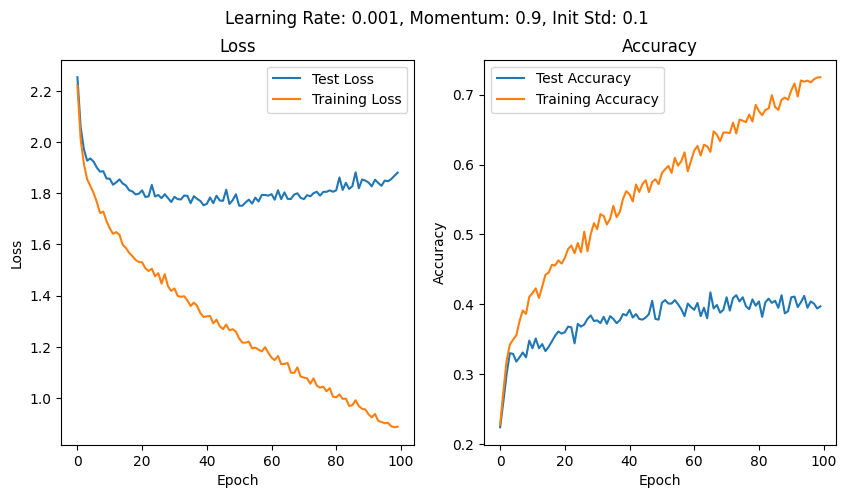

In [72]:
import matplotlib.pyplot as plt

def plot_graphs(test_losses, test_accuracies, training_losses, training_accuracies, title):
    print(f"Final Test Accuracy: {test_accuracies[-1]} and Loss: {test_losses[-1]}")

    # Plot training and test losses
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(test_losses, label='Test Loss')
    ax[0].plot(training_losses, label='Training Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()


    # Plot training and test accuracies
    ax[1].plot(test_accuracies, label='Test Accuracy')
    ax[1].plot(training_accuracies, label='Training Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    # Add title to the plot
    plt.suptitle(title)

    plt.show()

print("Training with best params found from grid search...")
model, test_losses, test_accuracies, training_losses, training_accuracies = train(lr, mu, std, num_ep=100, device='mps')
plot_graphs(test_losses, test_accuracies, training_losses, training_accuracies, f'Learning Rate: {lr}, Momentum: {mu}, Init Std: {std}')


2. Optimization

Final Test Accuracy: 0.37700000405311584 and Loss: 2.9169809818267822


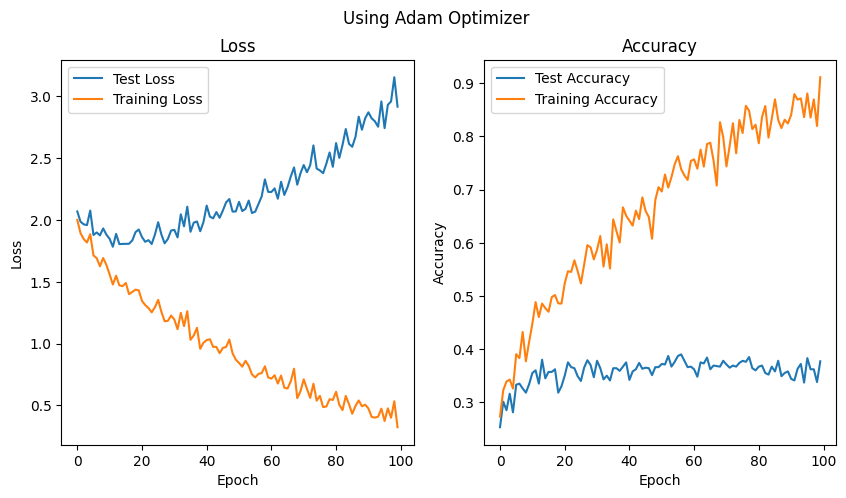

In [81]:
model, test_losses, test_accuracies, training_losses, training_accuracies = train(lr, mu, std, num_ep=100, device='mps', adam_optim=True)
plot_graphs(test_losses, test_accuracies, training_losses, training_accuracies, "Using Adam Optimizer")

Although it looks like Adam achieved accuracy that was a bit less good than SGD, we can see that the loss decreases faster and the accuracy increases faster - specificall by around epoch 25 the accuracy looks like it peaks for the test set while in SGD it takes it around 60 epochs to peak. Also in loss we can see that Adam crosses 1.0 at around epoch 50 while in SGD it takes around 100 epochs. This makes sense since Adam is known for optimizing faster but generalizing worse than SGD.

3. Initialization

Final Test Accuracy: 0.40400001406669617 and Loss: 1.7595407962799072


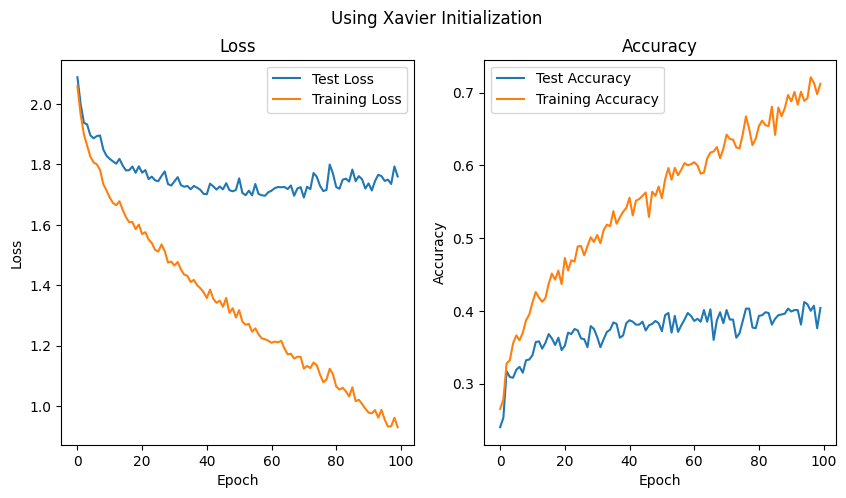

In [83]:
model, test_losses, test_accuracies, training_losses, training_accuracies = train(lr, mu, std, num_ep=100, device='mps', xavier=True)
plot_graphs(test_losses, test_accuracies, training_losses, training_accuracies, "Using Xavier Initialization")

We can see that Xavier initialization improved the accuracy, but required more epochs to reach the same accuracy as the baseline (80 vs 60).

4. Regularization

Final Test Accuracy: 0.37400001287460327 and Loss: 1.8511998653411865


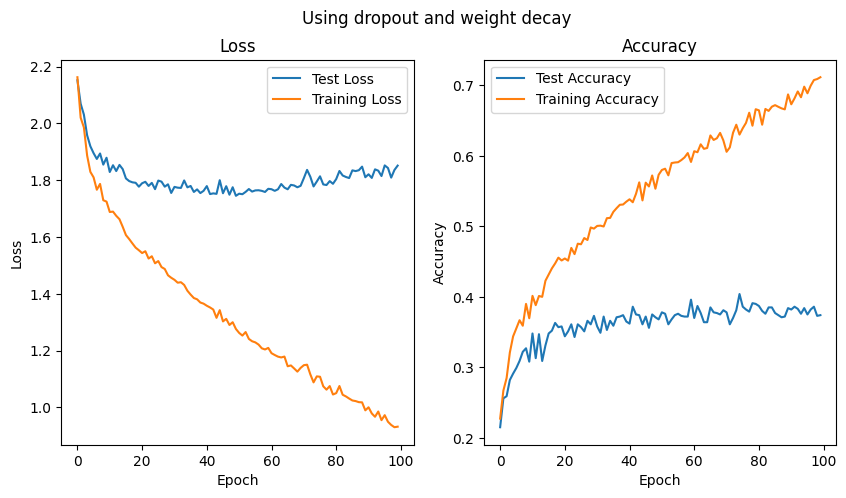

In [84]:
model, test_losses, test_accuracies, training_losses, training_accuracies = train(lr, mu, std, num_ep=100, device='mps', decay_and_dropout=True)
plot_graphs(test_losses, test_accuracies, training_losses, training_accuracies, "Using dropout and weight decay")

We can see that dropout and regularization didn't have that much of an effect in this case, both in terms of accuracy and speed. It does look like the peak accuracy is a bit higher, but not by much.

5. Preprocessing

Final Test Accuracy: 0.21299999952316284 and Loss: 4.66573429107666


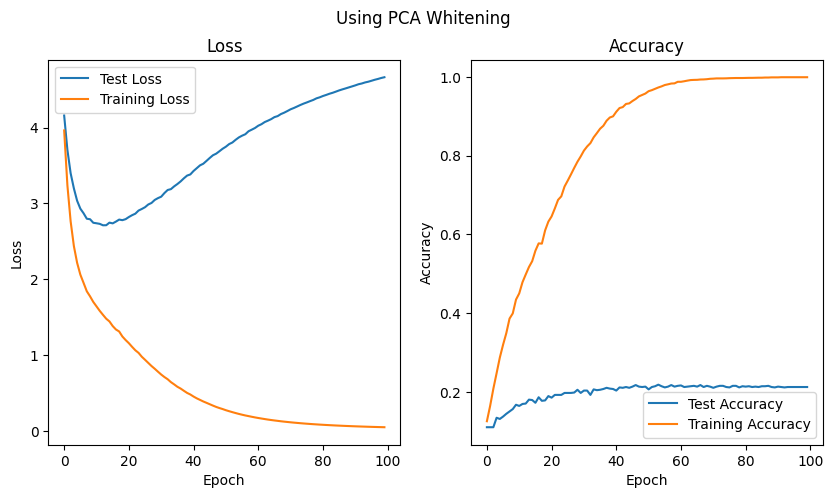

In [86]:
model, test_losses, test_accuracies, training_losses, training_accuracies = train(lr, mu, std, num_ep=100, device='mps', pca_whitening=True)
plot_graphs(test_losses, test_accuracies, training_losses, training_accuracies, "Using PCA Whitening")

This seems to have made accuracy much worse. It might be that the decrease in dimesions just loses too much information, leading to worse accuracy. The time to convergence is smaller, reaching it at around 50 epochs, but it might just be because the highest accuracy is much lower.

6. Network Width

Width 64 Test Accuracy: 0.3610000014305115, Loss: 1.7878199815750122
Width 1024 Test Accuracy: 0.39399999380111694, Loss: 2.061422348022461
Width 4096 Test Accuracy: 0.3659999966621399, Loss: 2.8230175971984863


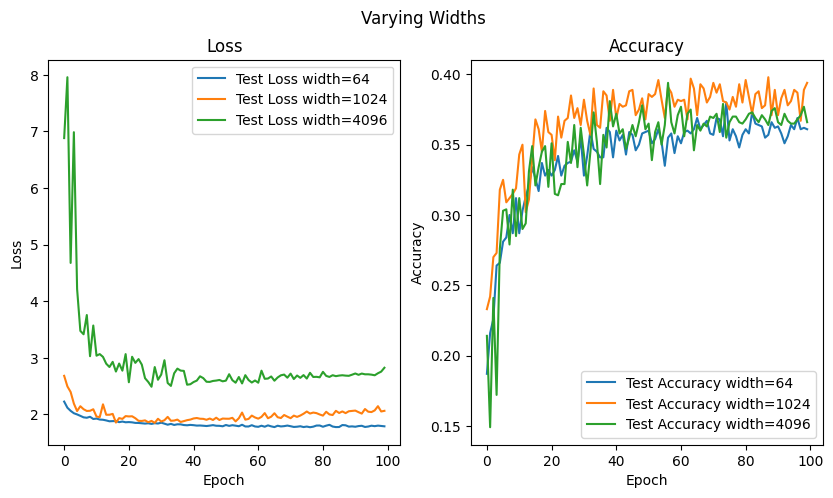

In [90]:
model1, test_losses1, test_accuracies1, training_losses1, training_accuracies1 = train(lr, mu, std, num_ep=100, device='mps', width=2**6)
model2, test_losses2, test_accuracies2, training_losses2, training_accuracies2 = train(lr, mu, std, num_ep=100, device='mps', width=2**10)
model3, test_losses3, test_accuracies3, training_losses3, training_accuracies3 = train(lr, mu, std, num_ep=100, device='mps', width=2**12)

print(f"Width {2**6} Test Accuracy: {test_accuracies1[-1]}, Loss: {test_losses1[-1]}")
print(f"Width {2**10} Test Accuracy: {test_accuracies2[-1]}, Loss: {test_losses2[-1]}")
print(f"Width {2**12} Test Accuracy: {test_accuracies3[-1]}, Loss: {test_losses3[-1]}")

# Plot training and test losses
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(test_losses1, label=f'Test Loss width={2**6}')
ax[0].plot(test_losses2, label=f'Test Loss width={2**10}')
ax[0].plot(test_losses3, label=f'Test Loss width={2**12}')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot training and test accuracies
ax[1].plot(test_accuracies1, label=f'Test Accuracy width={2**6}')
ax[1].plot(test_accuracies2, label=f'Test Accuracy width={2**10}')
ax[1].plot(test_accuracies3, label=f'Test Accuracy width={2**12}')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Add title to the plot
plt.suptitle('Varying Widths')
plt.show()

We can see that a narrower network suffers in terms of accuracy, while a wider one (1024) improves it - but that making it too wide makes it worse again. Interestingly the widest network doesn't even seem to achieve a lower loss.

7. Network Depth

Depth 3 Test Accuracy: 0.375, Loss: 1.810434341430664
Depth 4 Test Accuracy: 0.41600000858306885, Loss: 1.8270244598388672
Depth 10 Test Accuracy: 0.30799999833106995, Loss: 1.8336807489395142


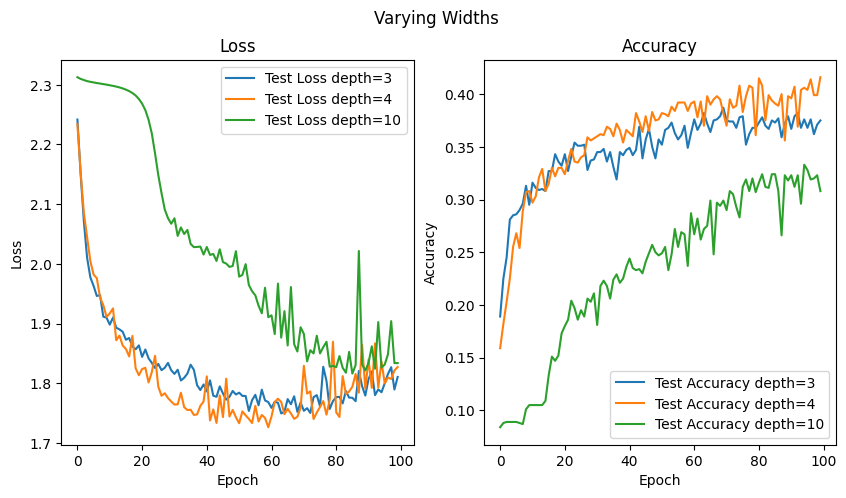

In [91]:
model1, test_losses1, test_accuracies1, training_losses1, training_accuracies1 = train(lr, mu, std, num_ep=100, device='mps', width=64, depth=3)
model2, test_losses2, test_accuracies2, training_losses2, training_accuracies2 = train(lr, mu, std, num_ep=100, device='mps', width=64, depth=4)
model3, test_losses3, test_accuracies3, training_losses3, training_accuracies3 = train(lr, mu, std, num_ep=100, device='mps', width=64, depth=10)

print(f"Depth 3 Test Accuracy: {test_accuracies1[-1]}, Loss: {test_losses1[-1]}")
print(f"Depth 4 Test Accuracy: {test_accuracies2[-1]}, Loss: {test_losses2[-1]}")
print(f"Depth 10 Test Accuracy: {test_accuracies3[-1]}, Loss: {test_losses3[-1]}")

# Plot training and test losses
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(test_losses1, label='Test Loss depth=3')
ax[0].plot(test_losses2, label='Test Loss depth=4')
ax[0].plot(test_losses3, label='Test Loss depth=10')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot training and test accuracies
ax[1].plot(test_accuracies1, label='Test Accuracy depth=3')
ax[1].plot(test_accuracies2, label='Test Accuracy depth=4')
ax[1].plot(test_accuracies3, label='Test Accuracy depth=10')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Add title to the plot
plt.suptitle('Varying Widths')
plt.show()

Similarly to the previous experiment, here the medium depth again faired the best, achieving the highest accuracy of all the experiments. The deepest network faired terribly, possibly due to overfitting - it also took the longest to converge.

100%|██████████| 50/50 [04:42<00:00,  5.64s/it]


RNN Test Loss: 1.0644782053683411e-05
LSTM Test Loss: 2.326035538668947e-06


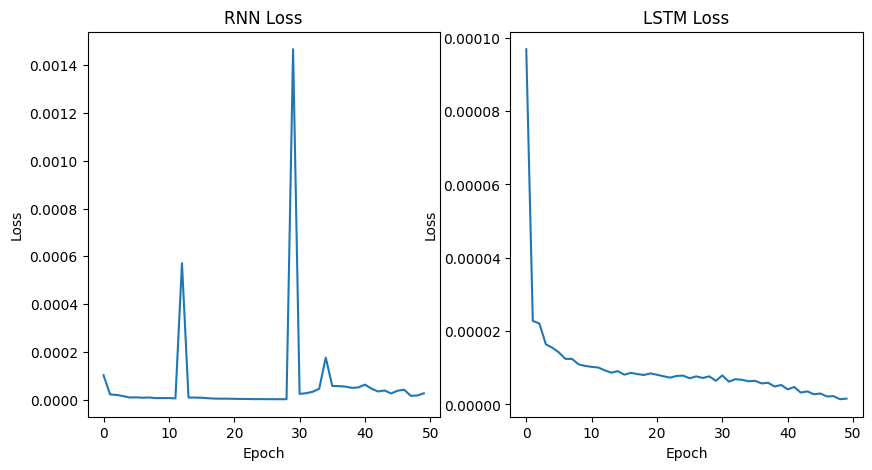

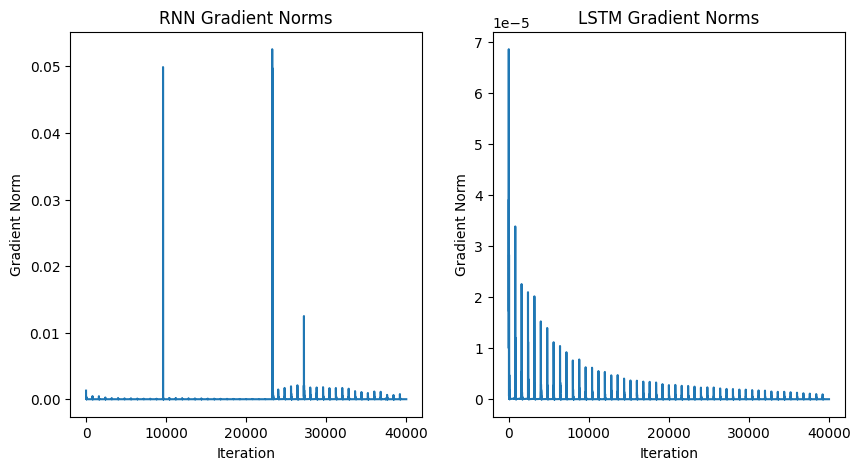

In [224]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate a sine wave dataset - this can be a simple 'dataset' for time series prediction upon which we can test our RNN and LSTM models
# and perhaps see the vanishing/exploding gradient problem.
def generate_sine_wave(seq_length, num_sequences):
    x = np.linspace(0, num_sequences * np.pi, seq_length * num_sequences)
    y = np.sin(x)
    data = y.reshape((num_sequences, seq_length, 1))
    return data

# Arbitraryish hyperparameters
seq_length = 50
num_sequences = 1000
hidden_size = 100
num_epochs = 50
learning_rate = 0.001

# Generate our sine wave 'dataset'
data = generate_sine_wave(seq_length, num_sequences)
train_data = torch.Tensor(data[:-200])
test_data = torch.Tensor(data[-200:])

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        # Generate prediction and hidden state based on input and previous hidden state
        out, hidden = self.rnn(x, hidden)
        out = self.output(out[:, -1, :])
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        # Generate prediction and hidden state based on input and previous hidden state
        out, hidden = self.lstm(x, hidden)
        out = self.output(out[:, -1, :])
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size),
                torch.zeros(1, batch_size, self.hidden_size))

# Training function
def train_model(model, train_data, num_epochs, learning_rate):
    # Saw this recommended in a few places - using MSE loss and Adam optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Keep track of gradients for the first layer and the losses
    all_gradients = []
    losses = []

    for _ in tqdm(range(num_epochs)):
        total_loss = 0
        for sequence in train_data:
            # Add a batch dimension
            sequence = sequence.unsqueeze(0)

            # Zero the gradients
            optimizer.zero_grad()

            # Get the output and hidden state from the model
            hidden = model.init_hidden(sequence.size(0))
            output, hidden = model(sequence, hidden)

            # Calculate loss and backpropagate
            loss = criterion(output, sequence[:, -1, :])
            loss.backward()
            
            # Collect gradients for the first layer - best way I found to extract the gradients
            gradients = model.rnn.weight_hh_l0.grad.cpu().data.numpy() if isinstance(model, RNNModel) else model.lstm.weight_hh_l0.grad.cpu().data.numpy()
            all_gradients.append(np.mean(np.abs(gradients)))
            
            # Update the model
            optimizer.step()
            total_loss += loss.item()

        losses.append(total_loss / len(train_data))
        
    
    return all_gradients, losses

# Initialize models
rnn_model = RNNModel(input_size=1, hidden_size=hidden_size, output_size=1)
lstm_model = LSTMModel(input_size=1, hidden_size=hidden_size, output_size=1)

# Train models
rnn_gradients, rnn_losses = train_model(rnn_model, train_data, num_epochs, learning_rate)
lstm_gradients, lstm_losses = train_model(lstm_model, train_data, num_epochs, learning_rate)

def get_model_accuracy(model, test_data):
    criterion = nn.MSELoss()
    total_loss = 0
    for sequence in test_data:
        sequence = sequence.unsqueeze(0)
        hidden = model.init_hidden(sequence.size(0))
        output, hidden = model(sequence, hidden)
        loss = criterion(output, sequence[:, -1, :])
        total_loss += loss.item()
    return total_loss / len(test_data)

print(f'RNN Test Loss: {get_model_accuracy(rnn_model, test_data)}')
print(f'LSTM Test Loss: {get_model_accuracy(lstm_model, test_data)}')

# Plot the losses
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(rnn_losses)
ax[0].set_title('RNN Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(lstm_losses)
ax[1].set_title('LSTM Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.show()

# Plot the gradients
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(rnn_gradients)
ax[0].set_title('RNN Gradient Norms')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Gradient Norm')

ax[1].plot(lstm_gradients)
ax[1].set_title('LSTM Gradient Norms')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Gradient Norm')

plt.show()

In both models we can see the vanishing and exploding gradient problem - in RNN we can see extreme rapid spikes in the norms, and in LSTM we see the gradients vanishing to zero. We haven't learned this yet in class, but from what I read online this is to be expected in RNNs and LSTMs due to their sequential nature - caused by repeated multiplication of the same weights, which if >1 will explode and if <1 will vanish. Although we can see that this problem is less severe in LSTMs, perhaps due to the gating mechanism meant to prevent this.